# Visualising taxa abundance

In [1]:
setwd("/mnt/c/Users/Cedric/Desktop/git_repos/blood_microbiome")
require(tidyverse)
require(ggplot2)
require(data.table)
require(foreach)
require(compositions)
require(ggpubr)
require(see)
require(doParallel)
require(Rtsne)
require(vegan)
registerDoParallel(cores=8)

Loading required package: tidyverse

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when


Loading required packag

## Pre-process data

#### Metadata

In [2]:
get_meta_cols <- function(meta) {
    meta_cols <- colnames(meta)[grep("kit|flow_cell|instrument_id|site_supplying", colnames(meta))]
    to_exclude <- c("library_prep_kit", "hiseq_xtm_flow_cell_v2_5_id")
    meta_cols <- meta_cols[!(meta_cols %in% to_exclude)]
    return(meta_cols)
}


to_retain <- fread("data/samples_above_95_reads.txt")$npm_research_id

meta <- fread("data/SG10K_Health_metadata.n10714.16March2021.parsed.csv") %>%
    filter(npm_research_id %in% to_retain)

meta_cols <- get_meta_cols(meta)

head(meta)

npm_research_id,multiplex_pool_id,supplier_id,gis_internal_sample_id,site_supplying_sample,year_of_birth,supplied_gender,self_reported_ethnicity,extraction_kit,date_of_dna_extraction,⋯,supplied_and_computed_gender_match,sop_agreement_for_coverage__14/_28_for_15x/30x,sample_life_cycle,current,source_cohort,original_supplier_id,duplicate_info,duplicate,duplicate_pair,removal_requested_by_supplier
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
WHB10000,MUX9693,00358,HELIOS_00358_1,HELIOS,1982,F,Chinese,abGENIX Whole Blood Genomic DNA Extraction Kit,6/6/2019,⋯,Y,Y,HELIOS VCF,Y,HELIOS,00358,Unknown,PASS,Unknown,Unknown
WHB10001,MUX9693,00359,HELIOS_00359_1,HELIOS,1979,F,Chinese,abGENIX Whole Blood Genomic DNA Extraction Kit,6/6/2019,⋯,Y,Y,HELIOS VCF,Y,HELIOS,00359,Unknown,PASS,Unknown,Unknown
WHB10002,MUX9695,00360,HELIOS_00360_1,HELIOS,1970,F,Chinese,abGENIX Whole Blood Genomic DNA Extraction Kit,6/6/2019,⋯,Y,N,HELIOS VCF,Y,HELIOS,00360,Unknown,PASS,Unknown,Unknown
WHB10003,MUX9694,00361,HELIOS_00361_1,HELIOS,1969,M,Chinese,abGENIX Whole Blood Genomic DNA Extraction Kit,6/6/2019,⋯,Y,Y,HELIOS VCF,Y,HELIOS,00361,Unknown,PASS,Unknown,Unknown
WHB10005,MUX9694,00363,HELIOS_00363_1,HELIOS,1959,F,Chinese,abGENIX Whole Blood Genomic DNA Extraction Kit,6/6/2019,⋯,Y,N,HELIOS VCF,Y,HELIOS,00363,Unknown,PASS,Unknown,Unknown
WHB10006,MUX9694,00364,HELIOS_00364_1,HELIOS,1955,F,Chinese,abGENIX Whole Blood Genomic DNA Extraction Kit,6/6/2019,⋯,Y,Y,HELIOS VCF,Y,HELIOS,00364,Unknown,PASS,Unknown,Unknown


#### Host metadata (Shaw et al. 2020)

In [3]:
host_meta <- read.csv("data/PathogenVsHostDB-2019-05-30.csv")

known_human_pathogens <- unique((host_meta %>% filter(Human == "Yes"))$Species)

head(host_meta)
head(known_human_pathogens)

,X,Type,Phylum,Class,Order,Family,Genus,Species,Human,Zoonotic,⋯,Genome,Gsize,ProteinCount,PercentGC,HostSpeciesPHB,HostSpecies.new,N.genomes,Genome.size,Genome.GC,Genome.genes
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Actinomycetaceae,Actinobaculum,Actinobaculum massiliense,Yes,No,⋯,NA,NA,NA,NA,Homosapiens,Homo sapiens,1,2.065190,60.2,1784
2,2,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Actinomycetaceae,Actinobaculum,Actinobaculum suis,No,No,⋯,NA,NA,NA,NA,Susscrofadomesticus,Sus scrofa domesticus,4,2.277433,57.8,1852
3,3,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Actinomycetaceae,Actinomyces,Actinomyces bovis,Yes,Yes,⋯,NA,NA,NA,NA,Homosapiens,Homo sapiens,1,2.595570,64.1,2199
4,4,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Actinomycetaceae,Actinomyces,Actinomyces bovis,Yes,Yes,⋯,NA,NA,NA,NA,Oviscanadensis,Ovis canadensis,1,2.595570,64.1,2199
5,5,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Actinomycetaceae,Actinomyces,Actinomyces bovis,Yes,Yes,⋯,NA,NA,NA,NA,Ovisdalli,Ovis dalli,1,2.595570,64.1,2199
6,6,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Actinomycetaceae,Actinomyces,Actinomyces bovis,Yes,Yes,⋯,NA,NA,NA,NA,Bostaurus,Bos taurus,1,2.595570,64.1,2199


[1] "Actinobaculum massiliense" "Actinomyces bovis"        
[3] "Actinomyces cardiffensis"  "Actinomyces dentalis"     
[5] "Actinomyces europaeus"     "Actinomyces funkei"

#### Contaminant list

In [4]:
contam <- read.table("data/contaminant_list_salter_2014.txt", header = F, sep = ",")
contam_list <- str_trim(as.character(contam))
contam_list

[1] "Afipia"            "Aquabacterium"     "Asticcacaulis"    
 [4] "Aurantimonas"      "Beijerinckia"      "Bosea"            
 [7] "Bradyrhizobium"    "Brevundimonas"     "Caulobacter"      
[10] "Craurococcus"      "Devosia"           "Hoefleae"         
[13] "Mesorhizobium"     "Methylobacterium"  "Novosphingobium"  
[16] "Ochrobactrum"      "Paracoccus"        "Pedomicrobium"    
[19] "Phyllobacterium"   "Rhizobium"         "Roseomonas"       
[22] "Sphingobium"       "Sphingomonas"      "Sphingopyxis"     
[25] "Acidovorax"        "Azoarcus"          "Azospira"         
[28] "Burkholderia"      "Comamonas"         "Cupriavidus"      
[31] "Curvibacter"       "Delftia"           "Duganella"        
[34] "Herbaspirillum"    "Janthinobacterium" "Kingella"         
[37] "Leptothrix"        "Limnobacter"       "Massilia"         
[40] "Methylophilus"     "Methyloversatilis" "Oxalobacter"      
[43] "Pelomonas"         "Polaromonas"       "Ralstonia"        
[46] "Schlegelella"      "Sulfuritalea"      "Undibacterium"    
[49] "Variovorax"        "Acinetobacter"     "Enhydrobacter"    
[52] "Enterobacter"      "Escherichia"       "Nevskia"          
[55] "Pseudomonas"       "Pseudoxanthomonas" "Psychrobacter"    
[58] "Stenotrophomonas"  "Xanthomonas"       "Aeromicrobium"    
[61] "Arthrobacter"      "Beutenbergia"      "Brevibacterium"   
[64] "Corynebacterium"   "Curtobacterium"    "Dietzia"          
[67] "Geodermatophilus"  "Janibacter"        "Kocuria"          
[70] "Microbacterium"    "Micrococcus"       "Microlunatus"     
[73] "Patulibacter"      "Propionibacterium" "Rhodococcus"      
[76] "Tsukamurella"      "Abiotrophia"       "Bacillus"         
[79] "Brevibacillus"     "Brochothrix"       "Facklamia"        
[82] "Paenibacillus"     "Streptococcus"     "Chryseobacterium" 
[85] "Dyadobacter"       "Flavobacterium"    "Hydrotalea"       
[88] "Niastella"         "Olivibacter"       "Pedobacter"       
[91] "Wautersiella"      "Deinococcus"

### Load and parse data

In [5]:
load_data <- function(file_path) {
    df <- fread(file_path) %>%
        separate(sample, into = c(NA, "npm_research_id"), sep = "\\.")
    return(df)
}

In [6]:
rank <- "S"
n_subset <- 9999

species_df <- load_data(str_glue("data/temp_files_{n_subset}/07_abundance_matrix/abundance_matrix.subset_{n_subset}.{rank}.tsv")) %>%
      filter(npm_research_id %in% to_retain)

species_t <- t(species_df %>% select(-npm_research_id, -unclassified, -"Homo sapiens"))
species_t <- as.data.frame(species_t)
colnames(species_t) <- species_df$npm_research_id

#### Relative abundance

In [7]:
otu_to_RA <- function(df) {
    row_names <- df$npm_research_id
    RA_df <- t(apply(df[, 2:ncol(df)], 1, function(x) {x / sum(x)}))
    
    return(cbind(data.frame(npm_research_id = row_names), as.data.frame(RA_df, check.names = F)))
}

species_RA <- otu_to_RA(species_df %>% select(-unclassified, -"Homo sapiens"))

#### Prevalence

In [8]:
species_prev <- species_RA[, 2:ncol(species_RA)]
species_prev[species_prev > 0] <- 1
species_prev$npm_research_id <- species_RA$npm_research_id
head(species_prev)

,Paraburkholderia fungorum,Paraburkholderia xenovorans,Paraburkholderia hospita,Ralstonia pickettii,Ralstonia insidiosa,Ralstonia mannitolilytica,Ralstonia solanacearum,Burkholderia cepacia,Burkholderia sp. LA-2-3-30-S1-D2,Burkholderia metallica,⋯,Grapevine Cabernet Sauvignon reovirus,Delftia phage IME-DE1,Fowlpox virus,Bacillus sp. Pc3,Agrotis segetum nucleopolyhedrovirus B,Vibrio phage 11895-B1,Mycobacterium phage Milly,Cacao swollen shoot Togo A virus,Streptomyces phage phiSASD1,npm_research_id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,1,1,1,1,1,1,1,1,1,1,⋯,0,0,0,0,0,0,0,0,0,WHB669
2,1,0,0,1,1,0,1,1,0,0,⋯,0,0,0,0,0,0,0,0,0,WHB8678
3,1,0,0,1,1,1,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,WHH7080
4,0,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,WHB4818
5,1,0,1,1,1,1,1,1,0,1,⋯,0,0,0,0,0,0,0,0,0,WHB9470
6,0,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,WHB4637


#### CLR transform

In [9]:
RA_to_clr <- function(df) {
    row_names <- df$npm_research_id
    clr_df <- clr(df %>% select(where(is.numeric)))
    return(cbind(data.frame(npm_research_id = row_names), as.data.frame(clr_df, check.names = F)))
}

species_clr <- RA_to_clr(species_RA)
head(species_clr)

,npm_research_id,Paraburkholderia fungorum,Paraburkholderia xenovorans,Paraburkholderia hospita,Ralstonia pickettii,Ralstonia insidiosa,Ralstonia mannitolilytica,Ralstonia solanacearum,Burkholderia cepacia,Burkholderia sp. LA-2-3-30-S1-D2,⋯,Mycobacterium virus Che12,Grapevine Cabernet Sauvignon reovirus,Delftia phage IME-DE1,Fowlpox virus,Bacillus sp. Pc3,Agrotis segetum nucleopolyhedrovirus B,Vibrio phage 11895-B1,Mycobacterium phage Milly,Cacao swollen shoot Togo A virus,Streptomyces phage phiSASD1
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,WHB669,4.78256166,0.1004304,0.1004304,3.2991036,0.5058955,0.10043043,-0.59271675,0.1004304,-0.5927167,⋯,0,0,0,0,0,0,0,0,0,0
2,WHB8678,-0.07251289,0.0000000,0.0000000,0.7747850,2.5177543,0.00000000,-0.07251289,0.4383127,0.0000000,⋯,0,0,0,0,0,0,0,0,0,0
3,WHH7080,-0.77793530,0.0000000,0.0000000,-0.7779353,0.8315026,-0.08478812,-0.08478812,0.0000000,0.0000000,⋯,0,0,0,0,0,0,0,0,0,0
4,WHB4818,0.00000000,0.0000000,0.0000000,0.0000000,0.4173003,0.00000000,0.00000000,0.0000000,0.0000000,⋯,0,0,0,0,0,0,0,0,0,0
5,WHB9470,-0.24787608,0.0000000,-0.9410233,1.0048869,1.1384183,0.44527110,1.36156183,-0.2478761,0.0000000,⋯,0,0,0,0,0,0,0,0,0,0
6,WHB4637,0.00000000,0.0000000,0.0000000,0.0000000,0.1290949,0.00000000,0.00000000,0.0000000,0.0000000,⋯,0,0,0,0,0,0,0,0,0,0


In [10]:
species_long <- species_clr %>%
    pivot_longer(where(is.numeric), names_to = "taxa", values_to = "clr") %>%
    left_join(meta %>% select(all_of(c("npm_research_id", meta_cols))))


Joining, by = "npm_research_id"



### No. of non-contaminants per threshold

In [120]:
morsels <- foreach (file = files) %dopar% {
    thresholds <- gsub("parsed.NC.n9999.min_samples100.", "", file)
    thresholds <- gsub(".txt", "", thresholds)
    thresholds <- gsub("l", "", thresholds)
    thresholds <- str_split(thresholds, pattern = "h")[[1]]
    hq_p <- round(as.numeric(thresholds[1]))

    nc <- read.csv(str_glue("{res_dir}/{file}"))$non_contaminants

    known_contam_regex <- paste0(contam_list, collapse = "|")
    known_contam_regex

    known_contams_all <- all_genera[grepl(known_contam_regex, all_genera)]
    known_contams_nc <- nc[grepl(known_contam_regex, nc)]

    human_regex <- paste0(known_human_pathogens, collapse = "|")
    human_associated_nc <- nc[grepl(human_regex, nc)]
    human_associated_all <- all_genera[grepl(human_regex, all_genera)]

    tibble(percentile_threshold = hq_p, 
           n_non_contaminants = length(nc),
           kitome_associated = length(known_contams_nc), 
           human_associated = length(human_associated_nc))
}

result_df <- bind_rows(morsels)

percentile_threshold,n_non_contaminants,kitome_associated,human_associated,perc_kitome
<dbl>,<int>,<int>,<int>,<dbl>
0,653,226,76,0.3460949
1,601,198,71,0.3294509
2,545,166,64,0.3045872
3,491,150,59,0.3054990
4,440,141,57,0.3204545
5,401,123,52,0.3067332
6,362,108,43,0.2983425
7,314,94,38,0.2993631
8,283,88,34,0.3109541


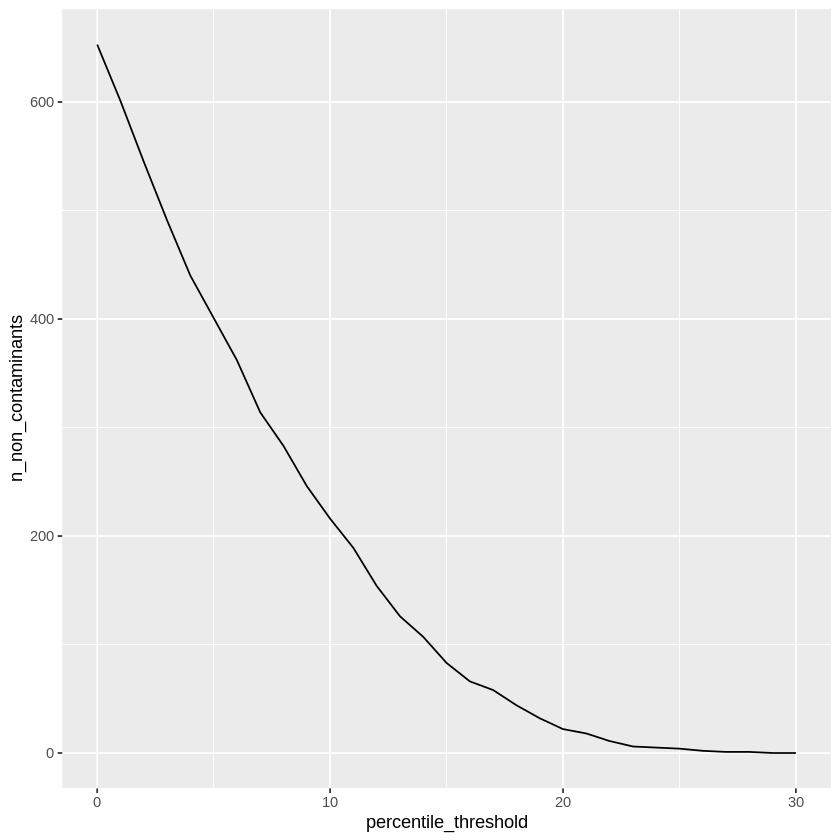

In [122]:
result_df %>% arrange(percentile_threshold) %>% 
    mutate(perc_kitome = kitome_associated/n_non_contaminants)

result_df %>%
    arrange(percentile_threshold) %>%
    ggplot(aes(x = percentile_threshold, y = n_non_contaminants)) +
    geom_line()

### Plot batch level abundance for single taxon

In [11]:
label_pos <- min(species_long$clr) - 0.5

n_fun <- function(x){
  return(data.frame(y = label_pos, label = paste0("n = ", length(x))))
}

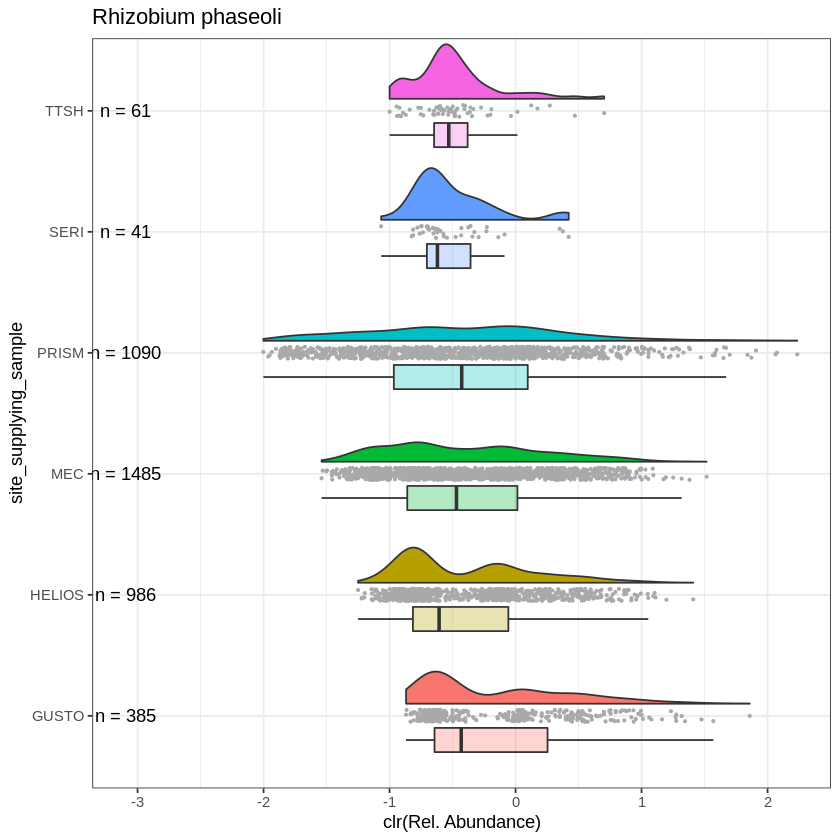

In [12]:
taxon <- "Rhizobium phaseoli"
column <- "site_supplying_sample"

species_long %>%
    filter(taxa == taxon, clr != 0) %>%
    ggplot(aes(x = get(column), y = clr, fill = get(column))) +
        theme_bw() +
        geom_boxplot(position = position_nudge(x = -0.2, y = 0), 
                   width = 0.2, 
                   outlier.shape = NA,
                   alpha = 0.3) +
        geom_violinhalf(position = position_nudge(x = 0.1, y = 0), alpha = 1) +
        geom_point(position = position_jitter(width = 0.05), 
                   color = "dark grey",
                     size = 0.5, 
                     alpha = 1) +
        stat_summary(fun.data = n_fun, geom = "text") +
        labs(x = "site_supplying_sample", y = "clr(Rel. Abundance)", title = taxon) +
        coord_flip() +
        theme(legend.position = "none")



### Plot batch level abundance for non-contaminants

In [13]:
get_meta_cols <- function(meta) {
    meta_cols <- colnames(meta)[grep("kit|flow_cell|instrument_id|site_supplying", colnames(meta))]
    to_exclude <- c("library_prep_kit", "hiseq_xtm_flow_cell_v2_5_id")
    meta_cols <- meta_cols[!(meta_cols %in% to_exclude)]
    return(meta_cols)
}


to_retain <- fread("data/samples_above_95_reads.txt")$npm_research_id

meta <- fread("data/SG10K_Health_metadata.n10714.16March2021.parsed.csv") %>%
    filter(npm_research_id %in% to_retain)

meta_cols <- get_meta_cols(meta)

species_long <- species_clr %>%
    pivot_longer(where(is.numeric), names_to = "taxa", values_to = "clr") %>%
    left_join(meta %>% select(all_of(c("npm_research_id", meta_cols))))

Joining, by = "npm_research_id"



In [44]:
res_dir <- "results/decontamination/clr_decontamination"
files <- list.files(res_dir)
files <- files[grepl("parsed.NC.n9999", files)]
# files <- files[!grepl("samples10.", files)]
files <- files[grepl("samples100", files)]

perc_t <- "l15h85"
file <- files[grepl(perc_t, files)]
nc <- read.csv(str_glue("{res_dir}/{file}"))$non_contaminants
length(nc)

[1] 83

In [15]:
# label_pos <- min(species_long$clr) - 0.5

# n_fun <- function(x){
#   return(data.frame(y = label_pos, label = paste0("n = ", length(x))))
# }

# for (column in meta_cols) {
#     plots_without_zeros <- foreach (taxon = nc) %dopar% {
#         species_long %>%
#     filter(taxa == taxon, clr != 0, get(column) != "Unknown") %>%
#             ggplot(aes(x = get(column), y = clr, fill = get(column))) +
#                 theme_bw() +
#                 geom_boxplot(position = position_nudge(x = -0.2, y = 0), 
#                            width = 0.2, 
#                            outlier.shape = NA,
#                            alpha = 0.3) +
#                 geom_violinhalf(position = position_nudge(x = 0.1, y = 0), alpha = 1) +
#                 geom_point(position = position_jitter(width = 0.05), 
#                            color = "dark grey",
#                              size = 0.5, 
#                              alpha = 1) +
#                 stat_summary(fun.data = n_fun, geom = "text") +
#                 labs(x = column, y = "clr(Rel. Abundance)", title = taxon) +
#                 coord_flip() +
#                 theme(legend.position = "none")
#     }


#     pdf(str_glue("results/decontamination/clr_decontamination/clr_abundance.l{perc_t}.{column}.without_zeroes.pdf"))

#         for (plt in plots_without_zeros) {
#             print(plt)
#         }

#     dev.off()
    
#     stopImplicitCluster()
# }

### t-SNE

In [50]:
merged_RA <- species_clr %>%
    left_join(meta)

X <- merged_RA[, 1:ncol(species_clr)]
X <- X %>% select(-npm_research_id)
X_decon <- X %>% select(all_of(nc))
Y <- merged_RA[, (ncol(species_clr) + 1):ncol(merged_RA)]

fwrite(Y, "data/temp_files_9999/07_abundance_matrix/metadata_aitchinson_matrix.clr_decon.l15h85.subset_9999.S.tsv", sep = "\t")

Joining, by = "npm_research_id"



#### Compute Aitchinson distances for ordination
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5695134/

In [21]:
# require(amap)
# system.time({
#     X_dist <- as.matrix(Dist(as.matrix(X), method = "euclidean", nbproc = 10))
# })

# fwrite(X_dist, "data/temp_files_9999/07_abundance_matrix/aitchinson_matrix.subset_9999.S.tsv", sep = "\t", col.names = F)
X_dist <- as.matrix(fread("data/temp_files_9999/07_abundance_matrix/aitchinson_matrix.subset_9999.S.tsv"))

In [22]:
# system.time({
#     X_decon_dist <- as.matrix(Dist(as.matrix(X_decon), method = "euclidean", nbproc = 10))
# })

# fwrite(X_decon_dist, "data/temp_files_9999/07_abundance_matrix/aitchinson_matrix.clr_decon.l15h85.subset_9999.S.tsv", sep = "\t", col.names = F)
X_decon_dist <- as.matrix(fread("data/temp_files_9999/07_abundance_matrix/aitchinson_matrix.clr_decon.l15h85.subset_9999.S.tsv"))

#### Run t-SNE

In [23]:
perp <- 30
max_iter <- 5000
theta <- 0.5

tsne <- Rtsne(X_dist,
              verbose = T,
              perplexity = perp,
              max_iter = max_iter,
              is_distance = T,
              pca = T,
              theta = theta)

tsne_decon <- Rtsne(X_decon_dist,
              verbose = T,
              perplexity = perp,
              max_iter = max_iter,
              is_distance = T,
              pca = T,
              theta = theta)

Read the 8728 x 8728 data matrix successfully!
OpenMP is working. 1 threads.
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
Done in 12.78 seconds (sparsity = 0.017619)!
Learning embedding...
Iteration 50: error is 91.502304 (50 iterations in 1.62 seconds)
Iteration 100: error is 73.683020 (50 iterations in 1.61 seconds)
Iteration 150: error is 68.723916 (50 iterations in 1.67 seconds)
Iteration 200: error is 66.926891 (50 iterations in 1.73 seconds)
Iteration 250: error is 65.981542 (50 iterations in 1.72 seconds)
Iteration 300: error is 2.268311 (50 iterations in 1.55 seconds)
Iteration 350: error is 1.977502 (50 iterations in 1.47 seconds)
Iteration 400: error is 1.800363 (50 iterations in 1.44 seconds)
Iteration 450: error is 1.685758 (50 iterations in 1.48 seconds)
Iteration 500: error is 1.608012 (50 iterations in 1.55 seconds)
Iteration 550: error is 1.551723 (50 iterations in 1.50 seconds)
Iteration 600: error is 

#### Plot t-SNE

In [51]:
plot_df <- data.frame(tsne$Y, Y)
plot_df_decon <- data.frame(tsne_decon$Y, Y)


# Params
size <- 2
col <- "extraction_kit"
# pal <- c("red", "orange", "grey")

plt1 <- plot_df %>%
    filter(get(col) != "Unknown") %>%
    ggplot(aes(x = X1, y = X2, color = get(col))) +
        geom_point(size = size, alpha = 0.3) +
#         scale_color_manual(values = pal) +
        theme(axis.title = element_blank(),
              axis.text = element_blank(),
              panel.grid.major = element_blank(),
              panel.grid.minor = element_blank(),
              axis.ticks = element_blank()) +
    labs(color = col)

plt2 <- plot_df_decon %>%
    filter(get(col) != "Unknown") %>%
    ggplot(aes(x = X1, y = X2, color = get(col))) +
        geom_point(size = size, alpha = 0.3) +
#         scale_color_manual(values = pal) +
        theme(axis.title = element_blank(),
              axis.text = element_blank(),
              panel.grid.major = element_blank(),
              panel.grid.minor = element_blank(),
              axis.ticks = element_blank()) +
    labs(color = col)

combined_tsne <- ggpubr::ggarrange(plt1, plt2, ncol = 2, common.legend = T)
ggsave(str_glue("results/decontamination/clr_decontamination/tsne_before_after.{perc_t}.png"), combined_tsne, 
       dpi = 300,
       height = 5, width = 10)

In [16]:
all_genera <- colnames(species_clr)
all_genera <- all_genera[all_genera != "npm_research_id"]
head(all_genera)
length(all_genera)

[1] "Paraburkholderia fungorum"   "Paraburkholderia xenovorans"
[3] "Paraburkholderia hospita"    "Ralstonia pickettii"        
[5] "Ralstonia insidiosa"         "Ralstonia mannitolilytica"

[1] 5199

### Venn diagrams

In [ ]:
# require(VennDiagram)
#     venn_list_nc <- list(non_contaminants = nc,
#                       human_associated = human_associated_nc, 
#                       kitome_associated = known_contams_nc)

#     venn_list_all <- list(all_genera = all_genera,
#                       human_associated = human_associated_all, 
#                       kitome_associated = known_contams_all)
# venn.diagram(venn_list_all, filename = "results/decontamination/clr_decontamination/all_genera_venn.png",
#              category.names = c("All genera", "Human associated", "Kitome associated"),
#              print.mode = c("raw", "percent")
#              )

# venn.diagram(venn_list_nc, filename = "results/decontamination/clr_decontamination/identified_nc_genera_venn.png",
#              category.names = c("Non-contaminants", "Human associated", "Kitome associated"),
#              print.mode = c("raw", "percent")
#              )

### Max read counts

In [70]:
max_df <- species_df %>%
    pivot_longer(!npm_research_id, names_to = "taxa", values_to = "read_count") %>%
    group_by(taxa) %>%
    summarise(max_count = max(read_count)) %>%
    mutate(max_bins = case_when(max_count == 0 ~ "0",
                     max_count > 0 & max_count <= 10 ~ "1-10",
                     max_count > 10 & max_count <= 100 ~ "11-100",
                     max_count > 100 & max_count <= 500 ~ "101-500",
                     max_count > 500 & max_count <= 1000 ~ "501-1000",
                     max_count > 1000 & max_count <= 5000 ~ "1001-5000",
                     max_count > 5000 ~ ">5000")) %>%
    mutate(max_bins = factor(max_bins, levels = c("0", "1-10", "11-100", "101-500", "501-1000",
                                                    "1001-5000", ">5000")))


max_df %>% 
    filter(taxa %in% nc) %>%
    arrange(desc(max_count))

taxa,max_count,max_bins
<chr>,<dbl>,<fct>
Ralstonia solanacearum,181086,>5000
Cutibacterium acnes,22588,>5000
Moraxella osloensis,2378,1001-5000
Burkholderia cepacia,2105,1001-5000
Devosia sp. A16,2093,1001-5000
Burkholderia stabilis,1965,1001-5000
Orrella dioscoreae,1088,1001-5000
Mesorhizobium australicum,911,501-1000
Gemmatirosa kalamazoonesis,718,501-1000


#### Annotate with host metadata

In [81]:
human_regex <- paste0(known_human_pathogens, collapse = "|")
human_associated_nc <- nc[grepl(human_regex, nc)]
human_associated_all <- all_genera[grepl(human_regex, all_genera)]

max_df %>% 
    filter(taxa %in% nc) %>%
    arrange(desc(max_count)) %>%
    mutate(human_associated = ifelse(taxa %in% human_associated_all, "Yes", "No"))

taxa,max_count,max_bins,human_associated
<chr>,<dbl>,<fct>,<chr>
Ralstonia solanacearum,181086,>5000,No
Cutibacterium acnes,22588,>5000,No
Moraxella osloensis,2378,1001-5000,Yes
Burkholderia cepacia,2105,1001-5000,Yes
Devosia sp. A16,2093,1001-5000,No
Burkholderia stabilis,1965,1001-5000,Yes
Orrella dioscoreae,1088,1001-5000,No
Mesorhizobium australicum,911,501-1000,No
Gemmatirosa kalamazoonesis,718,501-1000,No


In [95]:
max_count_bar <- max_df %>% 
    filter(taxa %in% nc) %>%
    count(max_bins) %>%
    ggplot(aes(x = max_bins, y = n, fill = max_bins)) +
    geom_bar(stat = "identity") +
    labs(x = "Max read count", y = "No. of non-contaminant species") +
    theme(legend.position = "none") +
    geom_text(aes(x = 4.5, y = 40, 
                  label = str_glue("threshold = {perc_t} \n n_species = {length(nc)}")),
              hjust = 0) +
    geom_text(aes(label = n), vjust = 0)

ggsave(str_glue("results/decontamination/clr_decontamination/max_read_count_barplot.{perc_t}.png"), max_count_bar, 
       dpi = 300)

Saving 6.67 x 6.67 in image



### Case Study: Moraxella osloensis

In [102]:
col <- "extraction_kit"
taxon <- "Moraxella osloensis"
test <- species_prev %>% 
    left_join(meta) %>%
    group_by_at(c(col)) %>%
    summarise(sum = sum(get(taxon)))

test %>% mutate(prevalence = sum / as.vector(table(meta[, ..col])))


Joining, by = "npm_research_id"



extraction_kit,sum,prevalence
<chr>,<dbl>,<dbl>
abGENIX Whole Blood Genomic DNA Extraction Kit,1002,0.4392810
"Chemagic DNA Blood Kit (Perkin Elmer, MA)",351,0.3375000
Maxwell RSC Blood DNA Kit (AS1400),1338,0.6329234
QIAamp DNA Blood Mini Kit,274,0.4228395
QIAsymphony DSP DNA Midi Kit,385,0.3989637
QIAsymphony DSP DNA Mini Kit (192),419,0.7053872
Unknown,658,0.6058932


Overall prevalence of Moraxella osloensis = 0.507218148487626


In [119]:
read_t <- 50

for (read_t in c(10, 50, 100, 1000)) {
    overall_prev <- round(sum(species_df$`Moraxella osloensis` > read_t) / nrow(species_prev) * 100, 2)

    print(str_glue("Overall prevalence (>{read_t} reads) of {taxon} = {overall_prev}%"))
}

Overall prevalence (>10 reads) of Moraxella osloensis = 4.09%
Overall prevalence (>50 reads) of Moraxella osloensis = 1.09%
Overall prevalence (>100 reads) of Moraxella osloensis = 0.53%
Overall prevalence (>1000 reads) of Moraxella osloensis = 0.02%


In [134]:
tolower(gsub(" ", "_", taxon))

[1] "moraxella_osloensis"

In [138]:
read_t <- 100
taxon_name <- tolower(gsub(" ", "_", taxon))
to_save <- species_df %>%
    filter(get(taxon) > read_t) %>%
    select(npm_research_id)

fwrite(to_save, str_glue("results/decontamination/case_studies/samples_with_{taxon_name}_gt_{read_t}.txt"), col.names = F)